In [1]:
from loadTDMS import *
from fft_test import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [1]:
# date = 20211025
# date = 20211115
# date = 20220630
# date = 20221027
# date = 20230113
date = 20230123

## 平均化、窓関数など無しで、純粋にnumpyでfftするやつ

In [7]:
%matplotlib qt

N = 2**17
load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_10.tdms"
ae_d = load_tdms(load_path, ch_num=3)
ae_d = ae_d[1][0:N]
dt = 1/10**6
F = np.fft.fft(ae_d) # 変換結果
freq = np.fft.fftfreq(N, d=dt) # 周波数
print(freq[1:int(N/2)])

Amp = np.abs(F/(N/2)) # 振幅

fig, ax = plt.subplots()
ax.plot(freq[1:int(N/2)], Amp[1:int(N/2)])

ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()


20*np.log10(amp_) +85

[7.62939453e+00 1.52587891e+01 2.28881836e+01 ... 4.99977112e+05
 4.99984741e+05 4.99992371e+05]


In [15]:
%matplotlib qt
# データのパラメータ
N = int(25000)           # サンプル数

load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_10.tdms"
ae_d = load_tdms(load_path, ch_num=3)
ae_d = ae_d[1][0:N]

dt = 1/10**6          # サンプリング間隔
fc = 50000           # カットオフ周波数
t = np.arange(0, N*dt, dt)  # 時間軸
freq = np.linspace(0, 1.0/dt, N)  # 周波数軸
f = ae_d[:N]

# 高速フーリエ変換（周波数信号に変換）
F = np.fft.fft(f)

# # 正規化 + 交流成分2倍
# F = F/(N/2)
# F[0] = F[0]/2

# 配列Fをコピー
F2 = F.copy()
print(len(F2))

# ローパスフィル処理（カットオフ周波数を超える帯域の周波数信号を0にする）
F2[(freq < fc)] = 0

# 高速逆フーリエ変換（時間信号に戻す）
f2 = np.fft.ifft(F2)

# 振幅を元のスケールに戻す
# f2 = np.real(f2*N)

# グラフ表示

fig = plt.figure(figsize=(10.0, 8.0))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# 時間信号（元）
plt.subplot(221)
plt.plot(t, f, label='RAW')
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid()
leg = plt.legend(loc=1, fontsize=15)
leg.get_frame().set_alpha(1)

# 周波数信号(元)
plt.subplot(222)
# plt.plot(freq[1:int(N/2)], 20*np.log10(np.abs(F)[1:int(N/2)]), label='RAW_FFT')
plt.plot(freq[1:int(N/2)], np.abs(F)[1:int(N/2)], label='RAW_FFT')

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
leg = plt.legend(loc=1)
leg.get_frame().set_alpha(1)

# 時間信号(処理後)
plt.subplot(223)
plt.plot(t, f2, label='LPF500Hz')
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid()
leg = plt.legend(loc=1)
leg.get_frame().set_alpha(1)

# 周波数信号(処理後)
plt.subplot(224)
# plt.plot(freq[1:int(N/2)], 20*np.log10(np.abs(F2)[1:int(N/2)]), label='LPF500Hz_FFT')
plt.plot(freq[1:int(N/2)], np.abs(F2)[1:int(N/2)], label='LPF500Hz_FFT')

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
leg = plt.legend(loc=1)
leg.get_frame().set_alpha(1)
# plt.savefig('切削抵抗500Hz_lowpass_filter.png')

25000


C:\Users\pmg07\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


### 自作FFT(平均化、窓関数処理などあり）で、pathごとに、特定区間のFFT

In [5]:
for num in tqdm(range(121,461)):
    load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_{num}.tdms"
    ae_d = load_tdms(load_path, ch_num=3)
    ae_d = ae_d[1][1000000:1000000+25000]

    dt = 1/10**6
    split_t_r = 0.1 # 1つの枠で全体のどの割合のデータを分析するか。
    overlap = 0.5  # オーバーラップ率
    window_F = "hamming"  # 窓関数選択: hanning, hamming, blackman
    y_label = "amplitude"
    y_unit = "V"
    N = len(ae_d)
    fq = np.linspace(0, N*dt, N)  # 周波数軸　linspace(開始,終了,分割数)


    fq_, amp_ = FFT_main(fq, ae_d, dt, split_t_r, overlap, window_F)

    output_FN = rf"Z:\200 Produced_data\{date}\FFT\spindle\{num}.png"
    plot_FFT(fq_, amp_, output_FN, y_label, y_unit,num)

100%|██████████| 340/340 [25:04<00:00,  4.43s/it]


In [3]:
def fft_integrated_one_rotation_fig(start,end,num,j):
    load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_{num}.tdms"
    d = load_tdms(load_path, ch_num=3)
    d = d[1][start:end]
    
    dt = 1/10**6
    split_t_r = 0.1 # 1つの枠で全体のどの割合のデータを分析するか。
    overlap = 0.5  # オーバーラップ率
    window_F = "hamming"  # 窓関数選択: hanning, hamming, blackman
    y_label = "amplitude"
    y_unit = "V"
    N = len(d)
    fq = np.linspace(0, N*dt, N)  # 周波数軸　linspace(開始,終了,分割数)
    
    
    fq_, amp_ = FFT_main(fq, d, dt, split_t_r, overlap, window_F)

    output_FN = rf"Z:\200 Produced_data\{date}\FFTonePath_Focus\fig\FFT_{num}_{x}"
    plot_FFT(fq_, amp_, output_FN, y_label, y_unit,num)
    
    return 20*np.log10(amp_) +85

# -------↓-------↓-------↓-------↓-------↓-----↓-------↓-------↓-------↓

## 各pathごとの面積のnpy生成

In [ ]:
for i in range(1,121):
    mensekis = []
    for j in tqdm(range(0,1200)):#1200回転分（切削抵抗のところで1回転のサンプル数を8308と仮定した時の話
        num = i
        sample_num = 2**14  #2のn乗を優先
#         sample_num = 25000  #1回転のサンプル数を優先
        start = j * 25000
        end = start + sample_num
        fft_result = fft_integrated_one_rotation_do_not_to_csv(start,end,num,j)
        menseki = time_hist_integrator_rect(1,fft_result)
        mensekis.append(menseki)
    d = np.array(mensekis)
    np.save(rf"Z:\200 Produced_data\20221027\FFT\menseki\{num}", d)

## 各pathごとの面積の推移

In [ ]:
for num in tqdm(range(1,170)):
    fig = plt.figure()
    dd = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\{num}.npy")
    
    ax = fig.add_subplot(ylim=(11000,18000))

    plt.plot(dd)
    fig.savefig(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\推移\{num}.png")

## 各pathごとの面積histogram生成

In [ ]:
x_min = 10000
x_max = 18000
range_bin_width = range(x_min, x_max, 60)


for num in tqdm(range(1,170)):
    figure, ax = plt.subplots()
    dd = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\{num}.npy")
    hist_p = sns.distplot(dd, bins=range_bin_width, kde=False, rug=False)
    figure = hist_p.get_figure()
    hist_p.set_title(rf"{num}path")
    ax.set_ylim(0, 140)
    figure.savefig(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\{num}.png")

## 全pathの面積のheatmap

In [ ]:
dd3 = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\1.npy")
for num in tqdm(range(2,170)):
    dd2 = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\{num}.npy")
    dd3 = np.concatenate([dd3, dd2], axis=0)

dd4 = dd3.reshape(int(len(dd3)/591),591)

print(dd4.shape)

np.save(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\All", dd4)

## 全部の面積をプロット

In [ ]:
d = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\All.npy")
d = d.ravel()

In [ ]:
%matplotlib qt

fig = plt.figure()

w_size = 591 * 10
v = np.ones(w_size) / w_size
d_moving_avg = np.convolve(d, v, mode='valid') 

ax = fig.add_subplot()
ax.set_xticks(np.arange(1, 169*591, 591*40))
ax.set_xticklabels(np.arange(0,170,40))

# plt.plot(d, lineWidth="2")
plt.plot(d_moving_avg, lineWidth="4")

# -------↓-------↓-------↓-------↓-------↓-----↓-------↓-------↓-------↓

# -------↓-------↓-------↓-------↓-------↓-----↓-------↓-------↓-------↓

# -------↓-------↓-------↓-------↓-------↓-----↓-------↓-------↓-------↓

# -------↓-------↓-------↓-------↓-------↓-----↓-------↓-------↓-------↓

## 周波数帯に区切って、面積出す

In [35]:
# date = 20211025
# date = 20211115
# date = 20220630
# date = 20221027
# date = 20230113
date = 20230117
# date = "20230113+0117"

In [24]:
def get_tdms(num):
    load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_{num}.tdms"
    d = load_tdms(load_path, ch_num=3)
    return d[1]

In [25]:
for i in tqdm(range(1,121)):
    d = get_tdms(i)
    mensekis = []
    
    for j in range(0,1200):
        sample_num = 2**14
        start = j * 25000
        end = start + sample_num

        ds = d[start:end]
        
        N = len(ds)
        fq = np.linspace(0, N*dt, N)  # 周波数軸　linspace(開始,終了,分割数)
        
        fq_, amp_ = FFT_main(fq, ds, dt, split_t_r, overlap, window_F)
        amp_ = np.array(np.split(20*np.log10(amp_) +100, 10))

        menseki = np.sum(amp_, axis=1)
        mensekis.append(menseki)
#     np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\{i}", np.array(mensekis))
    np.save(rf"Z:\200 Produced_data\20230113+0117\AE\menseki\50khz\{i}", np.array(mensekis))              

100%|██████████| 120/120 [29:09<00:00, 14.58s/it]


In [42]:
for i in range(0,10):
    d1 = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\121.npy")
    d1 = d1.T
    dd = d1[i]
#     print(dd.shape)
    for num in range(122,461):
        d2 = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\{num}.npy")
        d2 = d2.T
        dd = np.concatenate([dd,d2[i]])
#         print(dd.shape)
    start = i * 50
    end = (i+1) *50
    dd = dd.reshape(int(len(dd)/1200),1200)
#     print(dd.shape)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}",dd)

### 20230113 + 20230117 統合

In [43]:
# date = "20230113+0117"
# date = 20230117

## 各周波数帯の中で、正規化してばらつきが一番大きい周波数帯を特定

In [44]:
from sklearn import preprocessing

In [45]:
d_min = []
d_max = []
spectrum = []
d_std = []

for i in range(0,10):
    start = i * 50
    end = (i+1) *50

    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}.npy")
    d = d.T
    d = d.ravel()
    
    d_min.append(np.min(d))
    d_max.append(np.max(d))
    spectrum.append(f"{start}-{end}")
    
    d = preprocessing.minmax_scale(d)
    d_std.append(np.std(d))

d_min = np.array(d_min)
d_max = np.array(d_max)
d_minmax_diff = d_max - d_min


dict1 = dict(spectrum = spectrum[:] ,min_ = d_min[:], max_ = d_max[:], diff_ = d_minmax_diff[:], d_std = d_std[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumMinMax.csv')


In [46]:
df = pd.read_csv(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumMinMax.csv")
df

,Unnamed: 0,spectrum,min_,max_,diff_,d_std
0,0,0-50,3940.766895,4271.655593,330.888698,0.113869
1,1,50-100,1660.773086,2363.692291,702.919205,0.093267
2,2,100-150,1218.542839,2011.067648,792.524809,0.095917
3,3,150-200,1050.526804,1999.036682,948.509878,0.155275
4,4,200-250,949.791295,2221.125969,1271.334674,0.205410
5,5,250-300,846.008818,2039.860839,1193.852021,0.196227
6,6,300-350,835.713996,2055.373265,1219.659268,0.186957
7,7,350-400,786.116564,1534.504571,748.388007,0.141034
8,8,400-450,793.026105,1383.862126,590.836021,0.126782
9,9,450-500,747.654253,1373.884312,626.230060,0.118651


## 各周波数帯の中で正規化(normalization)し、heatmap表示

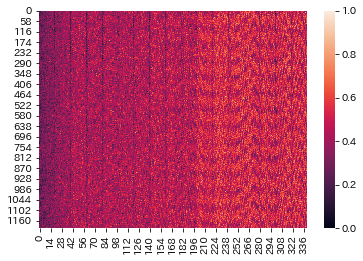

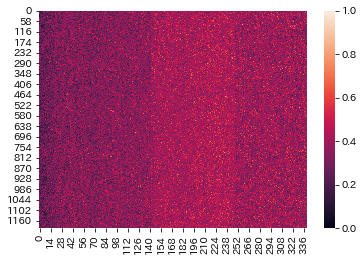

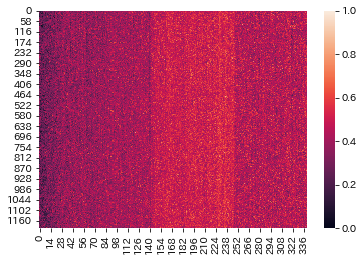

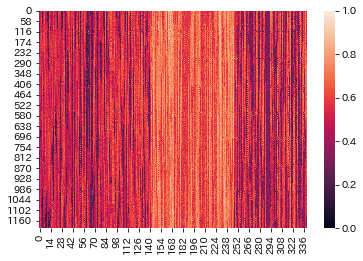

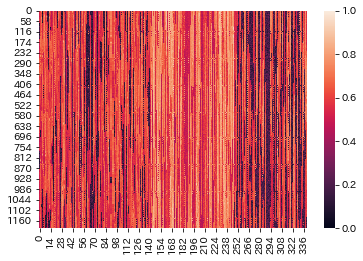

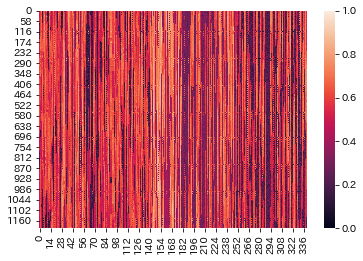

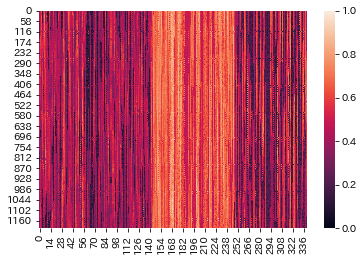

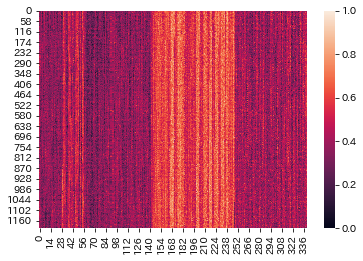

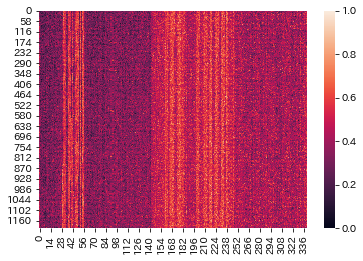

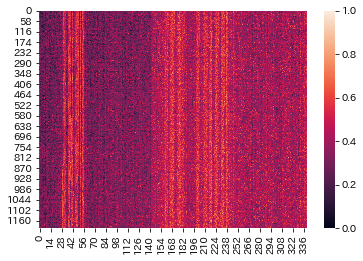

In [47]:
for i in range(0,10):
    figure, ax = plt.subplots()
    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}.npy")
    d = d.ravel()
#     print("---------------------")
    d = preprocessing.minmax_scale(d)
#     print(len(d)/169)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}Norm_flatten",d)
#     print(d.shape)
    d = d.reshape(340, int(len(d)/340))
#     print(d.shape)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}_Norm",d)
    sns.heatmap(d.T)
    figure.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}_Norm.png", dpi=500)

# 代表的な周波数帯のSだけ

In [61]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()

#all_path_num
a_p_n = 120
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10


ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
ax.set_xlabel(xlabel='Path Number')
ax.set_ylabel(ylabel='S (AE spectrum area)')
ax.grid()

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

ae1m = np.convolve(ae1,v, mode='valid')
ae6m = np.convolve(ae5,v, mode='valid')
ae9m = np.convolve(ae9,v, mode='valid')


ax.plot(ae1m, label="S (0-50)")
ax.plot(ae5m, label="S (250-350)")
ax.plot(ae9m, label="S (400-450)")
ax.legend()

# 代表的な周波数のSと切削抵抗の推移

In [62]:
cf_all = np.load(rf"Z:\200 Produced_data\20230113\CF\max8308\All.npy")
cf_all.shape

(144000,)

# cf, Sn{1,2,.....10}

In [2]:
date = "20230113+0117"
# date = 20230117

100%|██████████| 10/10 [06:38<00:00, 39.88s/it]


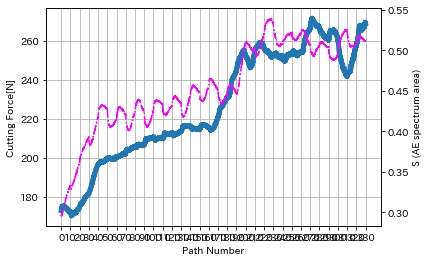

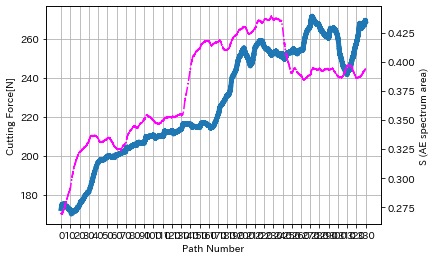

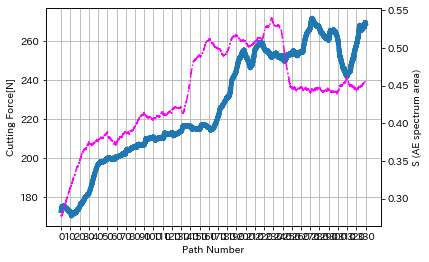

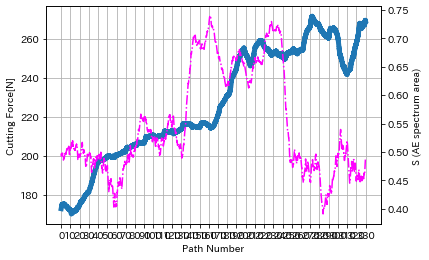

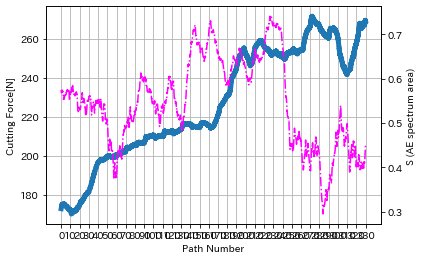

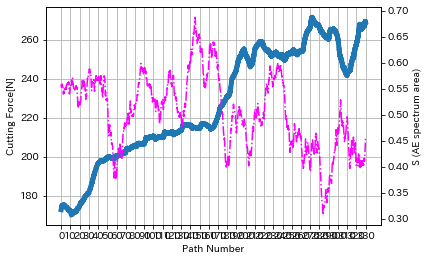

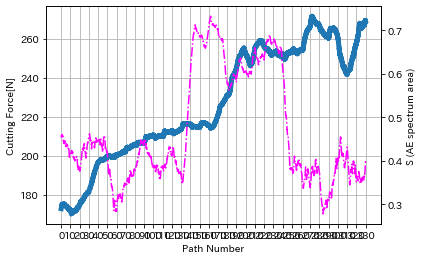

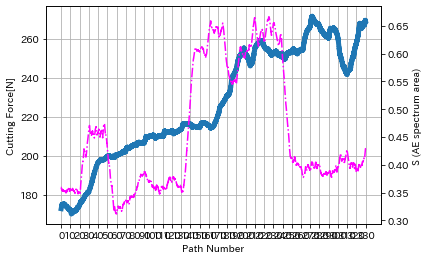

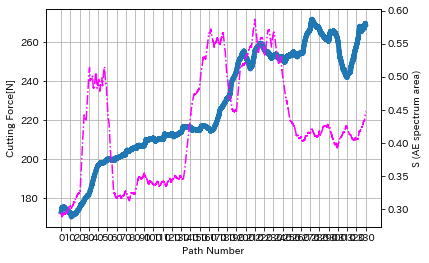

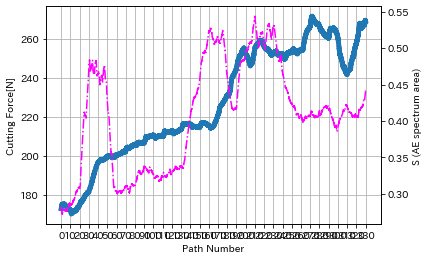

In [3]:
# %matplotlib qt

#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]


cf = np.load(rf"Z:\200 Produced_data\{date}\CF\max8308\All_delete_drift_460.npy")

for i in tqdm(range(0,10)):
    ae = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}Norm_flatten.npy")
    aem = np.convolve(ae,v, mode='valid')
    cfm = np.convolve(cf,v, mode='valid')
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
    ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
    ax.set_xlabel(xlabel='Path Number')
    ax.set_ylabel(ylabel='S (AE spectrum area)')
    ax.set_ylabel(ylabel='Cutting Force[N]')
    ax.tick_params(axis = 'x')
    ax.tick_params(axis = 'y')
    ax2 = ax.twinx()
    ax2.set_ylabel(ylabel='S (AE spectrum area)')
    ax.grid()
    ax.plot(cfm, lineWidth="5", label="cutting force")
    ax2.plot(aem, lineStyle="dashdot", color="magenta")
    plt.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\cf_and_S{i+1}.png")

## 欲しいAE_sとCF推移（個別に）matplotlib qt

In [28]:
#all_path_num
a_p_n = 360
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

In [25]:
cf_all = np.load(rf"Z:\200 Produced_data\{date}\CF\All_delete_drift_460.npy")
# cf_all = np.load(rf"Z:\200 Produced_data\{date}\CF\All_delete_drift_460.npy")
# cf_all = np.load(rf"Z:\200 Produced_data\20230117\CF\max8308\All_delete_drift_2.npy")
cf_m = np.convolve(cf_all,v, mode='valid')
# np.save(rf"Z:\200 Produced_data\20230117\CF\max8308\All_delete_drift_2_MA.npy", cf_m)

In [26]:
np.save(rf"Z:\200 Produced_data\{date}\CF\All_delete_drift_460_MA.npy",cf_m)

In [23]:
# date = 20230113
date = 20230117
# date = "20230113+0117"

In [29]:
for num in tqdm(range(0,10)):
    print(num+1)
    ae = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{num+1}Norm_flatten.npy")
    aem = np.convolve(ae,v, mode='valid')
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{num+1}Norm_flatten_MA",aem)

  0%|          | 0/10 [00:00<?, ?it/s]

1


 10%|█         | 1/10 [00:26<03:58, 26.55s/it]

2


 20%|██        | 2/10 [00:52<03:30, 26.37s/it]

3


 30%|███       | 3/10 [01:18<03:03, 26.17s/it]

4


 40%|████      | 4/10 [01:44<02:36, 26.12s/it]

5


 50%|█████     | 5/10 [02:10<02:10, 26.06s/it]

6


 60%|██████    | 6/10 [02:36<01:44, 26.08s/it]

7


 70%|███████   | 7/10 [03:02<01:18, 26.04s/it]

8


 80%|████████  | 8/10 [03:28<00:52, 26.13s/it]

9


 90%|█████████ | 9/10 [03:54<00:26, 26.10s/it]

10


100%|██████████| 10/10 [04:20<00:00, 26.04s/it]


In [18]:
num = 5

In [19]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()


#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
ax.set_xlabel(xlabel='Path Number')
ax.set_ylabel(ylabel='S (AE spectrum area)')
ax.set_ylabel(ylabel='Cutting Force[N]')
ax.tick_params(axis = 'x')
ax.tick_params(axis = 'y')
ax2 = ax.twinx()
ax2.set_ylabel(ylabel='S (AE spectrum area)')
ax.grid()

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

ae = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{num}Norm_flatten.npy")
aem = np.convolve(ae,v, mode='valid')

ax.plot(cf_m, lineWidth="5", label="cutting force")
ax2.plot(aem, lineStyle="dashdot", color="magenta")

# 移動平均同士の相関

In [ ]:
cf = np.load(rf"Z:\200 Produced_data\20230113\CF\max8308\All_delete_drift.npy")

In [24]:
#all_path_num
a_p_n = 120
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]


cf = np.load(rf"Z:\200 Produced_data\20230113\CF\max8308\All_delete_drift.npy")
correlation_list = []

spectrum = []


for i in tqdm(range(0,10)):
    ae = np.load(rf"Z:\200 Produced_data\20230113\AE\menseki\50khz\All{i+1}Norm_flatten.npy")
    aem = np.convolve(ae,v, mode='valid')
    cfm = np.convolve(cf,v, mode='valid')
    correlation = np.corrcoef(cfm, aem)
    correlation_list.append(correlation[0][1])
    print(correlation)
    start = i * 50
    end = (i+1) *50
    spectrum.append(f"{start}-{end}")


dict1 = dict(spectrum = spectrum[:] , corr = correlation_list[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumCorrelationWithCF_movingAVG(10path).csv')

100%|██████████| 10/10 [02:08<00:00, 12.81s/it]


In [25]:
df = pd.read_csv(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumCorrelationWithCF_movingAVG(10path).csv")
df

,Unnamed: 0,spectrum,corr
0,0,0-50,0.716562
1,1,50-100,0.883206
2,2,100-150,0.826945
3,3,150-200,0.755456
4,4,200-250,0.685250
5,5,250-300,0.714328
6,6,300-350,0.753623
7,7,350-400,0.904846
8,8,400-450,0.937271
9,9,450-500,0.940764


In [95]:
correlation = np.corrcoef(cfm, ae1m)
correlation[0][1]

-0.0073098609171975285

In [103]:
cfm = np.load(rf"Z:\200 Produced_data\20230113\CF\max8308\All_Norm.npy")
cfm = np.convolve(cfm,v,mode='valid')
len(cfm)

132001

In [108]:
c1 = np.corrcoef(cfm, ae1m)[0][1]
c2 = np.corrcoef(cfm, ae2m)[0][1]
c3 = np.corrcoef(cfm, ae3m)[0][1]
c4 = np.corrcoef(cfm, ae4m)[0][1]
c5 = np.corrcoef(cfm, ae5m)[0][1]
c6 = np.corrcoef(cfm, ae6m)[0][1]
c7 = np.corrcoef(cfm, ae7m)[0][1]
c8 = np.corrcoef(cfm, ae8m)[0][1]
c9 = np.corrcoef(cfm, ae9m)[0][1]
c10 = np.corrcoef(cfm, ae10m)[0][1]

In [17]:
#all_path_num
a_p_n = 340
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

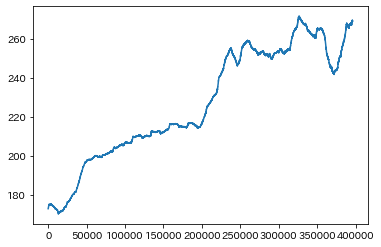

In [19]:
cfm = np.load(rf"\\192.168.201.182\users\park\200 Produced_data\20230117\CF\max8308\All_delete_drift_2_MA.npy")
len(cfm)
plt.plot(cfm)

408000


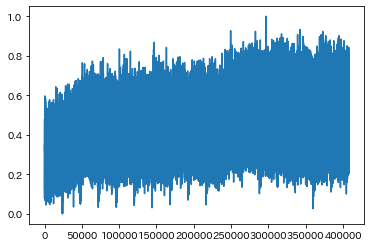

In [13]:
aem = np.load(rf"\\192.168.201.182\users\park\200 Produced_data\20230117\AE\menseki\50khz\All{i+1}Norm_flatten.npy")

print(len(aem))   
plt.plot(aem)

In [20]:
correlation_list = []

spectrum = []


for i in tqdm(range(0,10)):
    aem = np.load(rf"\\192.168.201.182\users\park\200 Produced_data\20230117\AE\menseki\50khz\All{i+1}Norm_flatten.npy")
    print(len(aem))
    aem = np.convolve(aem,v, mode='valid')
    print(len(aem))
    np.save(rf"\\192.168.201.182\users\park\200 Produced_data\20230117\AE\menseki\50khz\All{i+1}Norm_flatten",aem)
    correlation = np.corrcoef(cfm, aem)
    correlation_list.append(correlation[0][1])
    print(correlation)
    start = i * 50
    end = (i+1) *50
    spectrum.append(f"{start}-{end}")


dict1 = dict(spectrum = spectrum[:] , corr = correlation_list[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'\\192.168.201.182\users\park\200 Produced_data\20230117\AE\menseki\50khz\EachSpectrumCorrelationWithCF_movingAVG(10path).csv')

  0%|          | 0/10 [00:00<?, ?it/s]

408000
396001


 10%|█         | 1/10 [00:26<04:02, 26.97s/it]

[[1.         0.93157157]
 [0.93157157 1.        ]]
408000
396001


 20%|██        | 2/10 [00:55<03:40, 27.57s/it]

[[1.         0.79092267]
 [0.79092267 1.        ]]
408000
396001


 30%|███       | 3/10 [01:25<03:16, 28.09s/it]

[[1.         0.72407056]
 [0.72407056 1.        ]]
408000
396001


 40%|████      | 4/10 [01:52<02:47, 27.95s/it]

[[1.         0.13038274]
 [0.13038274 1.        ]]
408000
396001


 50%|█████     | 5/10 [02:20<02:19, 27.89s/it]

[[ 1.         -0.16435866]
 [-0.16435866  1.        ]]
408000
396001


 60%|██████    | 6/10 [02:47<01:50, 27.66s/it]

[[ 1.         -0.52595595]
 [-0.52595595  1.        ]]
408000
396001


 70%|███████   | 7/10 [03:15<01:23, 27.68s/it]

[[1.         0.11850623]
 [0.11850623 1.        ]]
408000
396001


 80%|████████  | 8/10 [03:42<00:55, 27.57s/it]

[[1.         0.31472095]
 [0.31472095 1.        ]]
408000
396001


 90%|█████████ | 9/10 [04:10<00:27, 27.51s/it]

[[1.         0.42520404]
 [0.42520404 1.        ]]
408000
396001


100%|██████████| 10/10 [04:37<00:00, 27.78s/it]

[[1.         0.50453821]
 [0.50453821 1.        ]]


In [21]:
df = pd.read_csv(rf"\\192.168.201.182\users\park\200 Produced_data\20230117\AE\menseki\50khz\EachSpectrumCorrelationWithCF_movingAVG(10path).csv")
df

,Unnamed: 0,spectrum,corr
0,0,0-50,0.931572
1,1,50-100,0.790923
2,2,100-150,0.724071
3,3,150-200,0.130383
4,4,200-250,-0.164359
5,5,250-300,-0.525956
6,6,300-350,0.118506
7,7,350-400,0.314721
8,8,400-450,0.425204
9,9,450-500,0.504538
